In [5]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from aurora import Aurora
import importlib

import torch
from torch.utils.data import DataLoader

from bfm_finetune.aurora_mod import AuroraFlex, AuroraRaw
from bfm_finetune import plots_v2
from bfm_finetune.dataloaders.geolifeclef_species.dataloader import GeoLifeCLEFSpeciesDataset
from bfm_finetune.dataloaders.dataloader_utils import custom_collate_fn
from bfm_finetune.utils import load_checkpoint, seed_everything, load_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

seed_everything(42)

/home/tkhan/bfm-finetune/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
STORAGE_DIR: /projects/prjs1134/data/projects/biodt/storage


In [ ]:
base_model = Aurora(use_lora=True) # stabilise_level_agg=True
base_model.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt", strict=False) # strict=False
atmos_levels = (50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000)
base_model.to(device)

num_species = 500

In [ ]:
# PATH = "/home/thanasis.trantas/github_projects/bfm-finetune/outputs/2025-04-29/16-59-52"
# PATH = "/home/martino.mensio/projects/bfm/bfm-finetune/outputs/2025-04-30/09-39-45"
# PATH = "/home/thanasis.trantas/github_projects/bfm-finetune/outputs/2025-05-06/10-13-15-good-to-t1-only"
PATH = "/home/tkhan/bfm-finetune/outputs/2025-07-09/16-33-12"
CHECKPOINT_PATH = Path(PATH) / "checkpoints"
cfg = load_config(PATH)

In [ ]:
val_dataset = GeoLifeCLEFSpeciesDataset(num_species=num_species, mode="val", negative_lon_mode=cfg.dataset.negative_lon_mode)
val_dataloader = DataLoader(
        val_dataset,
        batch_size=1,
        shuffle=False,
        collate_fn=custom_collate_fn,
        num_workers=1,
    )

lat_lon = val_dataset.get_lat_lon()

files 1


In [ ]:
# model = AuroraFlex(base_model=base_model, in_channels=num_species, hidden_channels=160,
#                     out_channels=num_species, atmos_levels=atmos_levels, lat_lon=lat_lon,
#                     supersampling_cfg=cfg.model.supersampling)
model = AuroraRaw(base_model)
model.to(device)

params_to_optimize = model.parameters()
optimizer = torch.optim.AdamW(params_to_optimize, lr=1.0)

NameError: name 'AuroraRaw' is not defined

In [ ]:
_, _ = load_checkpoint(model, optimizer, CHECKPOINT_PATH)

/gpfs/home1/tkhan/bfm-finetune/bfm_finetune/utils.py:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path)


Loaded checkpoint from /home/tkhan/bfm-finetune/outputs/2025-07-09/16-33-12/checkpoints/best_checkpoint.pth (epoch 306, loss: 0.0130)


In [ ]:
importlib.reload(plots_v2)
import bfm_finetune.metrics as UM

-25.0 44.75


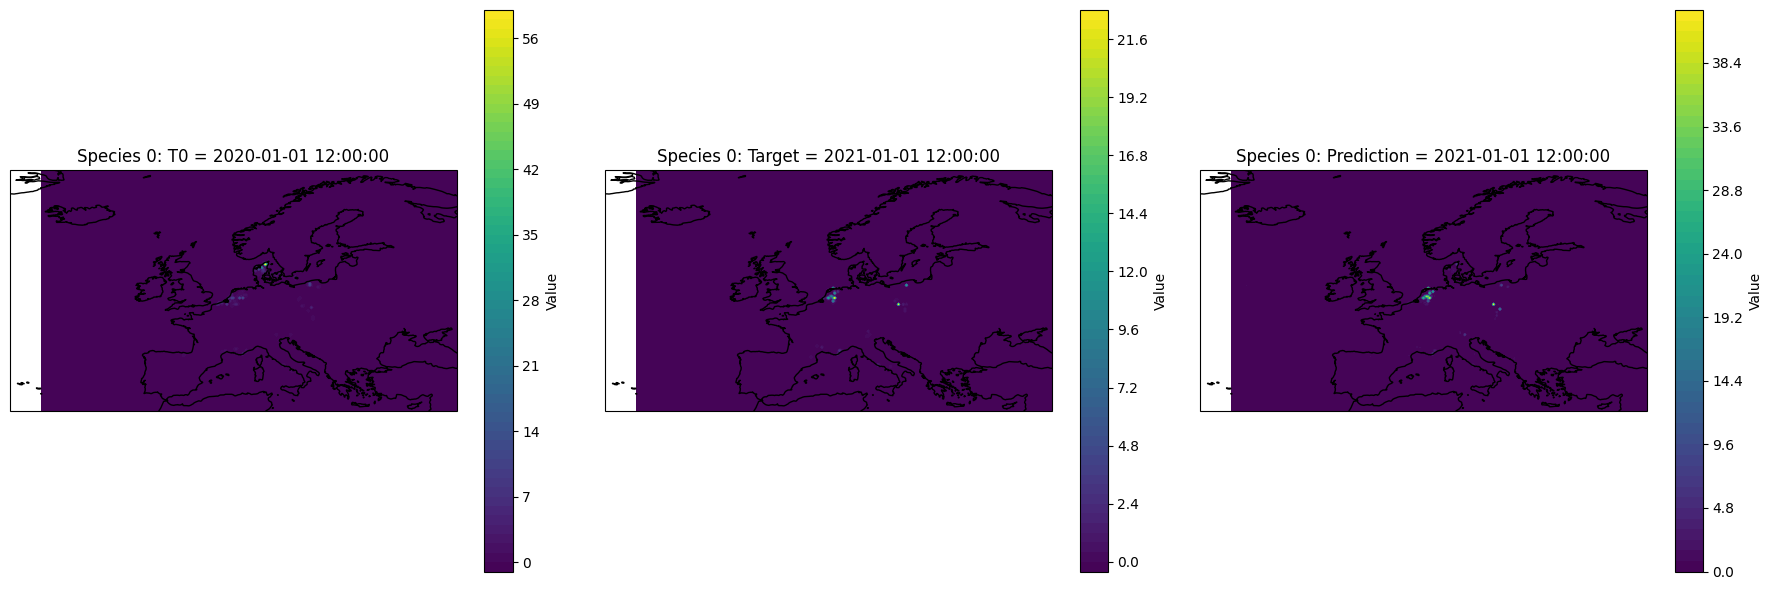

Preds shape torch.Size([1, 1, 500, 160, 280])


{'CRPS': 0.06676886230707169,
 'PoissonDev': 0.08925283700227737,
 'D2': 0.023430347442626953,
 'TSS': 0.7428932189941406}

In [ ]:
crps_sum, dev_sum, d2_sum, tss_sum, n = 0, 0, 0, 0, 0
for sample in val_dataloader:
    batch = sample["batch"]# .to(device)
    batch["species_distribution"] = batch["species_distribution"].to(device)
    target = sample["target"]
    with torch.inference_mode():
        prediction = model.forward(batch)
        unnormalized_preds = val_dataset.scale_species_distribution(prediction.clone(), unnormalize=True)
    # plot_channel_time_slices(batch["species_distribution"], channel_idx=0, cmap='plasma')
    # plot_channel_time_slices(prediction, channel_idx=0, cmap='plasma')
    un_preds = torch.nan_to_num(unnormalized_preds.float(), nan=0.0).clamp(min=0)

    plots_v2.plot_eval(batch, un_preds, Path("."), n_species_to_plot=1, save=False)
    print("Preds shape", unnormalized_preds.shape)
    # ---- metrics ------------------------------------------------------ #
    un_preds = un_preds.squeeze(0) # Remove the batch dim
    target_yr2 = batch["species_distribution"][:, 1]  # second year
    crps_sum += UM.crps(un_preds, target_yr2).item()
    dev = UM.poisson_deviance(un_preds, target_yr2)
    d2_sum += UM.explained_deviance(un_preds, target_yr2).item()
    dev_sum += dev.item()
    tss_sum += UM.tss(un_preds, target_yr2).item()
    n += 1
metrics = {
    "CRPS": crps_sum / n,
    "PoissonDev": dev_sum / n,
    "D2": d2_sum / n,
    "TSS": tss_sum / n,
}
metrics

In [11]:
from bfm_finetune.vis_tools import plot_change_map, plot_confusion_map, plot_taylor_single, plot_hexbin, plot_error_violin
lon = batch["metadata"]["lon"].cpu().numpy()
lat = batch["metadata"]["lat"].cpu().numpy()
species_i = 42

species_subset = [0, 1, 2] # select species
for s in species_subset:
    y0       = batch["species_distribution"][0, 0, s].cpu()
    y1_true  = batch["species_distribution"][0, 1, s].cpu()
    y1_pred  = un_preds[0, s].cpu()
    plot_change_map(lat, lon, y0, y1_true, y1_pred, s)
    # plot_taylor(lat, lon, y1_true.numpy(), y1_pred.numpy())
    # plot_taylor_single(y0.numpy().ravel(), y1_pred.numpy().ravel(), title="Year‑1 spatial skill")
    plot_confusion_map(lat, lon, y1_true.numpy(), y1_pred.numpy())

# global calibration
obs_all  = batch["species_distribution"][:, 1].reshape(-1).cpu()
pred_all = un_preds.reshape(-1).cpu()
plot_hexbin(pred_all, obs_all)

# violin of absolute errors  [species, cells]
abs_err = torch.abs(un_preds - batch["species_distribution"][:, 1]).cpu()
plot_error_violin(abs_err.reshape(500, -1).numpy())

ModuleNotFoundError: No module named 'skill_metrics'

In [ ]:
import importlib
from glob import glob
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm

from bfm_finetune import plots_v2 
from bfm_finetune.utils import (
    aggregate_into_latlon_grid,
    get_lat_lon_ranges,
    unroll_matrix_into_df,
)

In [ ]:
finetune_location = Path(
    "/projects/prjs1134/data/projects/biodt/storage/finetune"
 )  # snellius
#finetune_location = Path("../data/finetune")  # local
geolifeclef_location = finetune_location / "geolifeclef24"

# https://lab.plantnet.org/seafile/d/bdb829337aa44a9489f6/files/?p=%2FPresenceAbsenceSurveys%2FReadMe.txt
# presence-absence: in europe
pa_path = geolifeclef_location / "GLC24_PA_metadata_train.csv"

In [11]:
df = pd.read_csv(pa_path)
# 1483637
print(len(df))
# ['lon', 'lat', 'year', 'geoUncertaintyInM', 'areaInM2', 'region', 'country', 'speciesId', 'surveyId']
print(df.columns)
df["speciesId"].unique()  # 5016 species
df["surveyId"].unique()  # 88987 different surveys

# one survey:
df[df["surveyId"] == 212]
# 15 rows (15 different species are present, the other ones are absent?)

# one species?
df[df["speciesId"] == 6874.0]  # 924 rows: indicating where it appears (no time filter)

1483637
Index(['lon', 'lat', 'year', 'geoUncertaintyInM', 'areaInM2', 'region',
       'country', 'speciesId', 'surveyId'],
      dtype='object')


,lon,lat,year,geoUncertaintyInM,areaInM2,region,country,speciesId,surveyId
0,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,6874.0,212
2780,4.177610,43.848390,2017,1.0,NaN,MEDITERRANEAN,France,6874.0,7950
3112,15.485710,42.110800,2020,1.0,100.0,MEDITERRANEAN,Italy,6874.0,8669
3554,2.339040,43.145010,2018,1.0,NaN,MEDITERRANEAN,France,6874.0,9576
4185,5.486416,43.204942,2019,10.0,40.0,MEDITERRANEAN,France,6874.0,11039
...,...,...,...,...,...,...,...,...,...
1471906,3.144531,43.194955,2021,5.0,100.0,MEDITERRANEAN,France,6874.0,3888731
1471946,9.374250,40.938296,2018,10.0,200.0,MEDITERRANEAN,Italy,6874.0,3888840
1476908,5.672178,43.214294,2021,10.0,200.0,MEDITERRANEAN,France,6874.0,3902672
1478750,2.878387,43.047919,2021,5.0,50.0,MEDITERRANEAN,France,6874.0,3907609


In [12]:
step = 0.25
lat_range, lon_range = get_lat_lon_ranges(lat_step=step, lon_step=step)

In [13]:
df500 = df.groupby(['speciesId', 'year', 'lon','lat']).size().reset_index()
df500.head()

,speciesId,year,lon,lat,0
0,2.0,2017,1.963972,42.743200,1
1,2.0,2017,1.964000,42.743194,1
2,2.0,2017,1.973056,42.863889,1
3,2.0,2017,3.170130,44.616140,1
4,2.0,2018,0.129650,46.361030,1


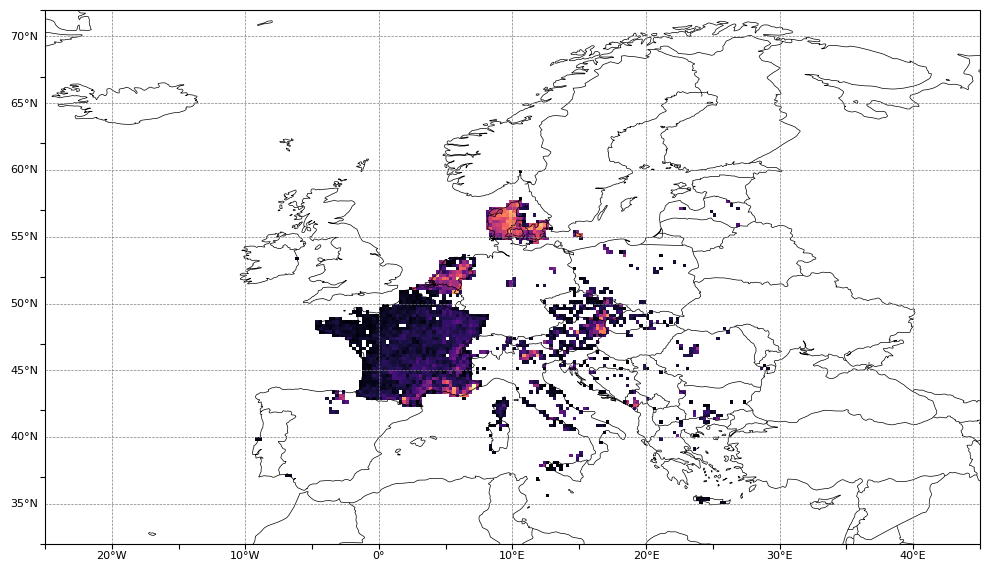

In [14]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Set new extent and grid
extent = (-25.0, 45.0, 32.0, 72.0)   # lon_min, lon_max, lat_min, lat_max
ddeg = 0.25

lon_edges = np.arange(extent[0], extent[1] + ddeg, ddeg)  # 281 edges, 280 cells
lat_edges = np.arange(extent[2], extent[3] + ddeg, ddeg)  # 161 edges, 160 cells
n_x, n_y = len(lon_edges) - 1, len(lat_edges) - 1         # n_x=280, n_y=160

# Compute richness per cell
lon_idx = np.searchsorted(lon_edges, df["lon"], side="right") - 1
lat_idx = np.searchsorted(lat_edges, df["lat"], side="right") - 1
inside = (lon_idx >= 0) & (lon_idx < n_x) & (lat_idx >= 0) & (lat_idx < n_y)

cell_key = lat_idx[inside] * n_x + lon_idx[inside]
richness = (
  pd.DataFrame({"cell": cell_key, "sp": df["speciesId"].values[inside]})
    .drop_duplicates()
    .groupby("cell").size()
    .reindex(range(n_x * n_y), fill_value=0)
    .values.reshape(n_y, n_x)
)

# Colormap and mask
cmap = plt.cm.magma.copy()
cmap.set_under("white")
rich_mask = np.ma.masked_where(richness == 0, richness)

# Plot
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=proj))

ax.pcolormesh(lon_edges, lat_edges, rich_mask,
        cmap=cmap, vmin=1, shading="auto", transform=proj)

ax.set_extent(extent, crs=proj)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

gl = ax.gridlines(draw_labels=True, linewidth=.5, color="gray", linestyle="--")
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = gl.ylabel_style = {'size': 8}

ax.set_xticks(np.arange(-25, 46, 5), crs=proj)
ax.set_yticks(np.arange(32, 73, 5), crs=proj)
ax.tick_params(axis="x", labelbottom=False, labeltop=False)
ax.tick_params(axis="y", labelleft=False, labelright=False)

fig.tight_layout()
#fig.savefig("species_richness_025deg_32-72N_-25-45E.png", dpi=300, bbox_inches="tight")
plt.show()


/scratch-local/tkhan.13097072/ipykernel_368578/1039600842.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pred_tensor = torch.load(pred_path, map_location="cpu")
/scratc

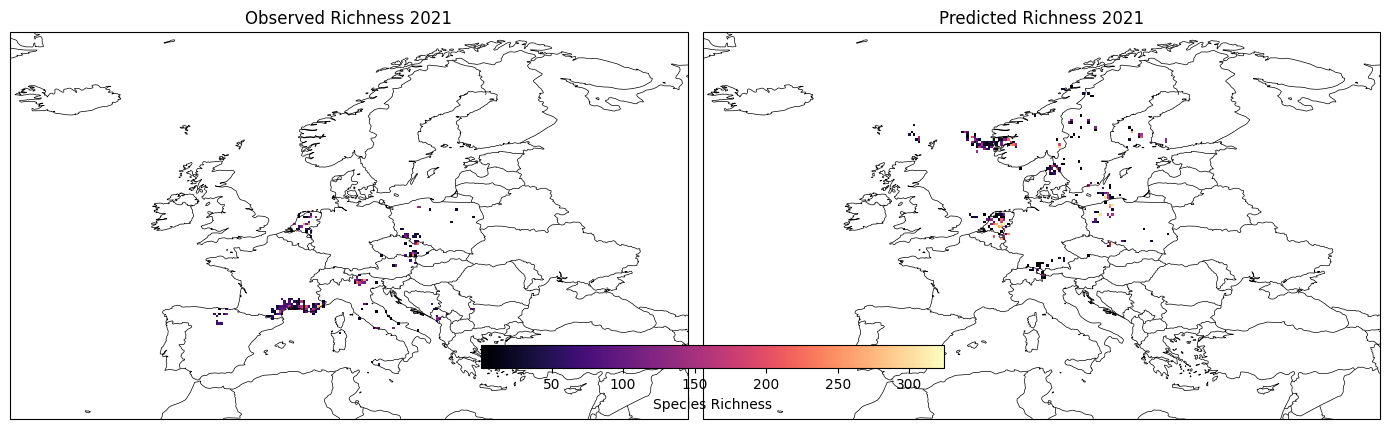

/scratch-local/tkhan.13097072/ipykernel_368578/1039600842.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


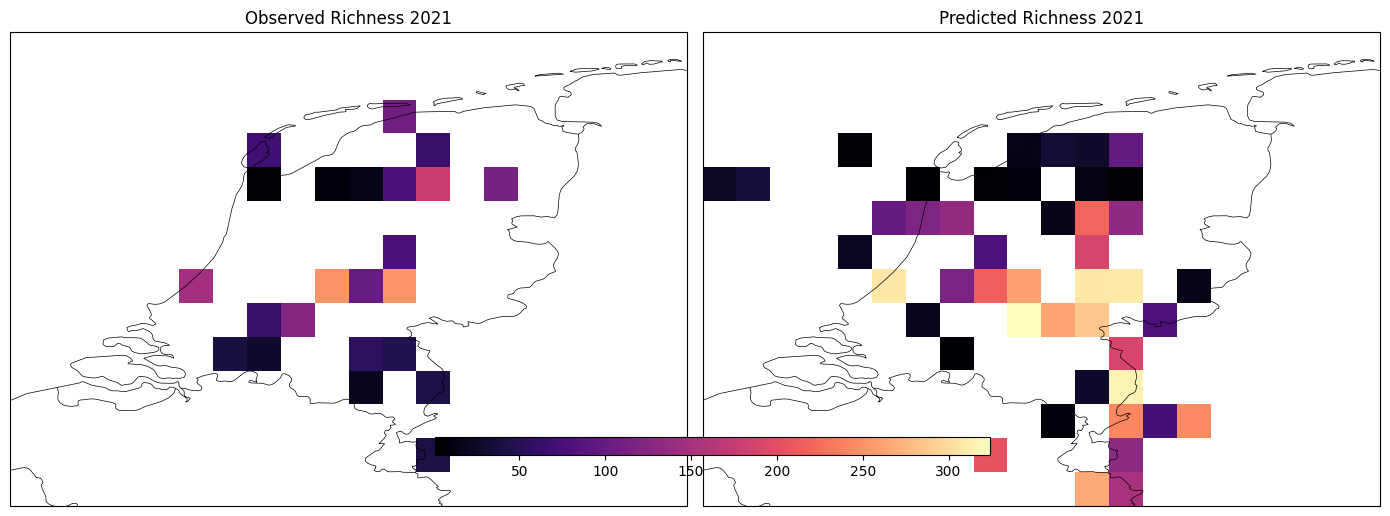

In [15]:
import torch
import matplotlib.pyplot as plt

# pred_tensor and pred_matrix already loaded above
# Read predictions for 2021
pred_path = "/home/tkhan/bfm-finetune/outputs_bfm_finetune_48800/predictions/finetune_predictions.pt"
pred_tensor = torch.load(pred_path, map_location="cpu")

# Compute predicted richness per cell as number of species with prediction > 0.5
pred_matrix = pred_tensor.squeeze().numpy()  # shape: (500, 160, 280)
pred_richness = (pred_matrix > 0.5).sum(axis=0)  # shape: (160, 280)

# Select only 2021 data for observed richness
df_2021 = df[df["year"] == 2021]
lon_idx_2021 = np.searchsorted(lon_edges, df_2021["lon"], side="right") - 1
lat_idx_2021 = np.searchsorted(lat_edges, df_2021["lat"], side="right") - 1
inside_2021 = (lon_idx_2021 >= 0) & (lon_idx_2021 < n_x) & (lat_idx_2021 >= 0) & (lat_idx_2021 < n_y)

cell_key_2021 = lat_idx_2021[inside_2021] * n_x + lon_idx_2021[inside_2021]
richness_2021 = (
    pd.DataFrame({"cell": cell_key_2021, "sp": df_2021["speciesId"].values[inside_2021]})
      .drop_duplicates()
      .groupby("cell").size()
      .reindex(range(n_x * n_y), fill_value=0)
      .values.reshape(n_y, n_x)
)

rich_mask_2021 = np.ma.masked_where(richness_2021 == 0, richness_2021)
pred_rich_mask = np.ma.masked_where(pred_richness == 0, pred_richness)

fig, axs = plt.subplots(1, 2, figsize=(14, 6), subplot_kw=dict(projection=proj))

im0 = axs[0].pcolormesh(lon_edges, lat_edges, rich_mask_2021, cmap=cmap, vmin=1, shading="auto", transform=proj)
axs[0].set_title("Observed Richness 2021")
axs[0].set_extent(extent, crs=proj)
axs[0].add_feature(cfeature.COASTLINE, linewidth=0.5)
axs[0].add_feature(cfeature.BORDERS, linewidth=0.5)

# For prediction, create new edges for 0.25° grid covering 160x280
pred_lat_edges = np.linspace(extent[2], extent[3], 161)  # 160 cells
pred_lon_edges = np.linspace(extent[0], extent[1], 281)  # 280 cells

im1 = axs[1].pcolormesh(pred_lon_edges, pred_lat_edges, pred_rich_mask, cmap=cmap, vmin=1, shading="auto", transform=proj)
axs[1].set_title("Predicted Richness 2021")
axs[1].set_extent(extent, crs=proj)
axs[1].add_feature(cfeature.COASTLINE, linewidth=0.5)
axs[1].add_feature(cfeature.BORDERS, linewidth=0.5)

fig.colorbar(im1, ax=axs, fraction=0.05, pad=0.07, label="Species Richness", location="bottom")
plt.tight_layout()
plt.show()

nl_extent = (3, 8, 50.5, 54)

fig, axs = plt.subplots(1, 2, figsize=(14, 6), subplot_kw=dict(projection=proj))

im0 = axs[0].pcolormesh(lon_edges, lat_edges, rich_mask_2021, cmap=cmap, vmin=1, shading="auto", transform=proj)
axs[0].set_title("Observed Richness 2021")
axs[0].set_extent(nl_extent, crs=proj)
axs[0].add_feature(cfeature.COASTLINE, linewidth=0.5)
axs[0].add_feature(cfeature.BORDERS, linewidth=0.5)

im1 = axs[1].pcolormesh(pred_lon_edges, pred_lat_edges, pred_rich_mask, cmap=cmap, vmin=1, shading="auto", transform=proj)
axs[1].set_title("Predicted Richness 2021")
axs[1].set_extent(nl_extent, crs=proj)
axs[1].add_feature(cfeature.COASTLINE, linewidth=0.5)
axs[1].add_feature(cfeature.BORDERS, linewidth=0.5)

fig.colorbar(im1, ax=axs, fraction=0.04, pad=0.02, aspect=30, location="bottom")
plt.tight_layout()
plt.show()



In [3]:
import torch
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd

# Collect Aurora predictions from the evaluation loop
print("Collecting Aurora predictions...")
aurora_predictions = []

# Reset the model to evaluation mode
model.eval()

# Run through validation set to get Aurora predictions
with torch.no_grad():
    for i, sample in enumerate(val_dataloader):
        batch = sample["batch"]
        batch["species_distribution"] = batch["species_distribution"].to(device)
        
        with torch.inference_mode():
            prediction = model.forward(batch)
            unnormalized_preds = val_dataset.scale_species_distribution(prediction.clone(), unnormalize=True)
        
        # Clean predictions
        un_preds = torch.nan_to_num(unnormalized_preds.float(), nan=0.0).clamp(min=0)
        
        # Convert to numpy and store
        pred_numpy = un_preds.squeeze().cpu().numpy()  # Remove batch dimension
        aurora_predictions.append(pred_numpy)
        
        print(f"Processed sample {i+1}, shape: {pred_numpy.shape}")
        
        # For demonstration, let's just use the first sample
        if i == 0:
            break

# Convert to single array
aurora_pred_matrix = aurora_predictions[0]  # shape: (500, 160, 280)

# Load BFM predictions (from your saved file)
bfm_pred_path = "/home/tkhan/bfm-finetune/outputs_bfm_finetune_48800/predictions/finetune_predictions.pt"
bfm_pred_tensor = torch.load(bfm_pred_path, map_location="cpu")
bfm_pred_matrix = bfm_pred_tensor.squeeze().numpy()  # shape: (500, 160, 280)

# Compute predicted richness per cell (number of species with prediction > 0.5)
aurora_pred_richness = (aurora_pred_matrix > 0.5).sum(axis=0)  # shape: (160, 280)
bfm_pred_richness = (bfm_pred_matrix > 0.5).sum(axis=0)  # shape: (160, 280)

# Select only 2021 data for observed richness (reusing your existing code)
df_2021 = df[df["year"] == 2021]
lon_idx_2021 = np.searchsorted(lon_edges, df_2021["lon"], side="right") - 1
lat_idx_2021 = np.searchsorted(lat_edges, df_2021["lat"], side="right") - 1
inside_2021 = (lon_idx_2021 >= 0) & (lon_idx_2021 < n_x) & (lat_idx_2021 >= 0) & (lat_idx_2021 < n_y)

cell_key_2021 = lat_idx_2021[inside_2021] * n_x + lon_idx_2021[inside_2021]
richness_2021 = (
    pd.DataFrame({"cell": cell_key_2021, "sp": df_2021["speciesId"].values[inside_2021]})
      .drop_duplicates()
      .groupby("cell").size()
      .reindex(range(n_x * n_y), fill_value=0)
      .values.reshape(n_y, n_x)
)

# Create masks
rich_mask_2021 = np.ma.masked_where(richness_2021 == 0, richness_2021)
aurora_rich_mask = np.ma.masked_where(aurora_pred_richness == 0, aurora_pred_richness)
bfm_rich_mask = np.ma.masked_where(bfm_pred_richness == 0, bfm_pred_richness)

# Create prediction grid edges
pred_lat_edges = np.linspace(extent[2], extent[3], 161)  # 160 cells
pred_lon_edges = np.linspace(extent[0], extent[1], 281)  # 280 cells

# Create three-panel comparison plot
proj = ccrs.PlateCarree()
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw=dict(projection=proj))

# Plot 1: Observed Richness 2021
im0 = axs[0].pcolormesh(lon_edges, lat_edges, rich_mask_2021, cmap=cmap, vmin=1, shading="auto", transform=proj)
axs[0].set_title("Observed Richness 2021", fontsize=14)
axs[0].set_extent(extent, crs=proj)
axs[0].add_feature(cfeature.COASTLINE, linewidth=0.5)
axs[0].add_feature(cfeature.BORDERS, linewidth=0.5)

# Plot 2: BFM Predicted Richness
im1 = axs[1].pcolormesh(pred_lon_edges, pred_lat_edges, bfm_rich_mask, cmap=cmap, vmin=1, shading="auto", transform=proj)
axs[1].set_title("BFM Predicted Richness", fontsize=14)
axs[1].set_extent(extent, crs=proj)
axs[1].add_feature(cfeature.COASTLINE, linewidth=0.5)
axs[1].add_feature(cfeature.BORDERS, linewidth=0.5)

# Plot 3: Aurora Predicted Richness
im2 = axs[2].pcolormesh(pred_lon_edges, pred_lat_edges, aurora_rich_mask, cmap=cmap, vmin=1, shading="auto", transform=proj)
axs[2].set_title("Aurora Predicted Richness", fontsize=14)
axs[2].set_extent(extent, crs=proj)
axs[2].add_feature(cfeature.COASTLINE, linewidth=0.5)
axs[2].add_feature(cfeature.BORDERS, linewidth=0.5)

# Add colorbar
fig.colorbar(im2, ax=axs, fraction=0.05, pad=0.07, label="Species Richness", location="bottom")
plt.tight_layout()
plt.show()

# Also create a zoomed-in view for Netherlands
nl_extent = (3, 8, 50.5, 54)

fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw=dict(projection=proj))

# Netherlands zoomed plots
im0 = axs[0].pcolormesh(lon_edges, lat_edges, rich_mask_2021, cmap=cmap, vmin=1, shading="auto", transform=proj)
axs[0].set_title("Observed Richness 2021 (Netherlands)", fontsize=14)
axs[0].set_extent(nl_extent, crs=proj)
axs[0].add_feature(cfeature.COASTLINE, linewidth=0.5)
axs[0].add_feature(cfeature.BORDERS, linewidth=0.5)

im1 = axs[1].pcolormesh(pred_lon_edges, pred_lat_edges, bfm_rich_mask, cmap=cmap, vmin=1, shading="auto", transform=proj)
axs[1].set_title("BFM Predicted Richness (Netherlands)", fontsize=14)
axs[1].set_extent(nl_extent, crs=proj)
axs[1].add_feature(cfeature.COASTLINE, linewidth=0.5)
axs[1].add_feature(cfeature.BORDERS, linewidth=0.5)

im2 = axs[2].pcolormesh(pred_lon_edges, pred_lat_edges, aurora_rich_mask, cmap=cmap, vmin=1, shading="auto", transform=proj)
axs[2].set_title("Aurora Predicted Richness (Netherlands)", fontsize=14)
axs[2].set_extent(nl_extent, crs=proj)
axs[2].add_feature(cfeature.COASTLINE, linewidth=0.5)
axs[2].add_feature(cfeature.BORDERS, linewidth=0.5)

fig.colorbar(im2, ax=axs, fraction=0.04, pad=0.02, aspect=30, location="bottom")
plt.tight_layout()
plt.show()

# Print some summary statistics
print("Summary Statistics:")
print(f"Observed richness - Mean: {np.mean(richness_2021[richness_2021 > 0]):.2f}, Max: {np.max(richness_2021)}")
print(f"BFM predicted richness - Mean: {np.mean(bfm_pred_richness[bfm_pred_richness > 0]):.2f}, Max: {np.max(bfm_pred_richness)}")
print(f"Aurora predicted richness - Mean: {np.mean(aurora_pred_richness[aurora_pred_richness > 0]):.2f}, Max: {np.max(aurora_pred_richness)}")

# Save Aurora predictions for future use
torch.save(torch.tensor(aurora_pred_matrix), "aurora_predictions.pt")
print("Aurora predictions saved to aurora_predictions.pt")

NameError: name 'model' is not defined